# Splitting up a Kyoto gas basket
This notebook demonstrates two different techniques to divide up the greenhouse gas projections from the Climate Action Tracker project. This reports only the total Kyoto gases. Using crunchers on each of the emissions separately will not produce consistent aggregates. We demonstrate first the DecomposeCollectionTimeDepRatio function, then the technique of using standard infillers for all but one gas (CO$_2$), then setting the CO$_2$ values to equal the leftover quantity. 

## Importing data and tools
This part collects and cleans the data.

In [1]:
import os.path

import pandas as pd
import pyam
import matplotlib.pyplot as plt
import numpy as np
import warnings

from silicone.utils import (
    download_or_load_sr15,
    convert_units_to_MtCO2_equiv,
    return_cases_which_consistently_split,
)
import silicone.multiple_infillers as mi
import silicone.database_crunchers as cr

<IPython.core.display.Javascript object>

pyam - INFO: Running in a notebook, setting `pyam` logging level to `logging.INFO` and adding stderr handler


In [2]:
input_kyoto_file = "./../input/DownloadedClimateActionTrackerData.csv"
input_complete_data = "./../input/complete_sr15.csv"
df = download_or_load_sr15(input_complete_data)
# We have to make the columns consistent
del df.data["meta"]
del df.data["subannual"]
df = pyam.IamDataFrame(df.data)

pyam.core - INFO: Reading file `./../input/complete_sr15.csv`


We have to format the CVS file to make a pyam dataframe.

In [3]:
kyoto_csv = pd.read_csv(input_kyoto_file, header=[0, 1], index_col=0)
kyoto_csv = kyoto_csv.transpose().reset_index()
kyoto_csv.head()

,level_0,level_1,2010,2011,2012,2013,2014,2015,2016,2017,...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
0,AR5 BAU,high,48.96,50.71,52.46,54.21,55.96,57.71,59.46,61.22,...,162.69,164.07,165.46,166.84,168.22,169.61,170.99,172.38,173.76,175.14
1,AR5 BAU,low,43.80,44.76,45.72,46.68,47.63,48.59,49.55,50.51,...,87.15,86.65,86.15,85.65,85.15,84.65,84.16,83.66,83.16,82.66
2,Pledges and targets,high,48.12,49.16,49.62,50.16,50.32,50.42,50.37,50.80,...,35.77,35.53,35.27,35.01,34.73,34.44,34.14,33.85,33.57,33.31
3,Pledges and targets,low,48.12,49.16,49.62,50.08,49.98,50.16,50.15,50.52,...,28.08,27.84,27.60,27.35,27.10,26.85,26.61,26.38,26.16,25.93
4,Current policy projections,high,48.13,49.18,49.65,50.33,50.46,50.59,50.65,51.22,...,55.05,54.87,54.70,54.53,54.37,54.24,54.12,53.97,53.80,53.64


In [4]:
kyoto_csv = kyoto_csv.rename(columns={"level_0": "model", "level_1": "scenario"})

In [5]:
aggregate = "Emissions|Kyoto Gases (AR4-GWP100)"
kyoto_csv["variable"] = aggregate
kyoto_csv["unit"] = "Mt CO2-equiv/yr" # We will convert units later
kyoto_csv["region"] = "World"

In [6]:
# There are too many cases so we leave some out
kyoto_df = pyam.IamDataFrame(kyoto_csv).filter(scenario="median", keep=False).filter(year=range(2010, 2020), keep=False)
kyoto_df.data["value"] = kyoto_df.data["value"] * 1000  #The csv values are in Gt CO2-equiv. 
kyoto_df.head()

,model,scenario,region,variable,unit,year,value
10,1.5C consistent,high,World,Emissions|Kyoto Gases (AR4-GWP100),Mt CO2-equiv/yr,2020,53830.0
11,1.5C consistent,high,World,Emissions|Kyoto Gases (AR4-GWP100),Mt CO2-equiv/yr,2021,51200.0
12,1.5C consistent,high,World,Emissions|Kyoto Gases (AR4-GWP100),Mt CO2-equiv/yr,2022,48570.0
13,1.5C consistent,high,World,Emissions|Kyoto Gases (AR4-GWP100),Mt CO2-equiv/yr,2023,45940.0
14,1.5C consistent,high,World,Emissions|Kyoto Gases (AR4-GWP100),Mt CO2-equiv/yr,2024,43310.0


Now we can set up the variables to decompose the aggregate into its components. 

In [7]:
components = [
    "Emissions|CO2",
    "Emissions|CH4",
    "Emissions|N2O",
    "Emissions|F-Gases",
]
unit_consistent_db = convert_units_to_MtCO2_equiv(
    df.filter(variable=components)
)
unit_consistent_db.variables(True)

,variable,unit
0,Emissions|CH4,Mt CO2-equiv/yr
1,Emissions|CO2,Mt CO2/yr
2,Emissions|F-Gases,Mt CO2-equiv/yr
3,Emissions|N2O,Mt CO2-equiv/yr


We interpolate to ensure that each model is represented in each year, to prevent variation in which models feature in particular years

In [8]:
for year in unit_consistent_db.filter(variable="Emissions|F-Gases")["year"].unique():
    year = int(year) # Hopefully temporary bug connected to how interpolate works in pyam
    unit_consistent_db.interpolate(year)

## Symmetric approach: use the decomposer to break up the aggregate
Here we use the DecomposeCollectionTimeDepRatio function, which calculates the average ratio between the basket value (the Kyoto gases) and the constituents for each time in the infiller database. In the event of negative total emissions, it will take the average only from data where the basket is negative in the infiller database. 

In [9]:
decomposer = mi.DecomposeCollectionTimeDepRatio(unit_consistent_db)
results = decomposer.infill_components(
    aggregate, components, 
    kyoto_df.filter(year=unit_consistent_db.filter(variable="Emissions|F-Gases")["year"].unique()), 
    use_ar4_data=True
)
results.head()

,model,scenario,region,variable,unit,year,value
0,1.5C consistent,high,World,Emissions|CH4,Mt CO2-equiv/yr,2020,10155.783964
1,1.5C consistent,high,World,Emissions|CH4,Mt CO2-equiv/yr,2025,7490.693789
2,1.5C consistent,high,World,Emissions|CH4,Mt CO2-equiv/yr,2030,5093.648185
3,1.5C consistent,high,World,Emissions|CH4,Mt CO2-equiv/yr,2035,4152.672670
4,1.5C consistent,high,World,Emissions|CH4,Mt CO2-equiv/yr,2040,3206.460653


In [10]:
results.variables(True)

,variable,unit
0,Emissions|CH4,Mt CO2-equiv/yr
1,Emissions|CO2,Mt CO2/yr
2,Emissions|F-Gases,Mt CO2-equiv/yr
3,Emissions|N2O,Mt CO2-equiv/yr


Text(0, 0.5, 'Mt CO$_2$-equiv/yr')

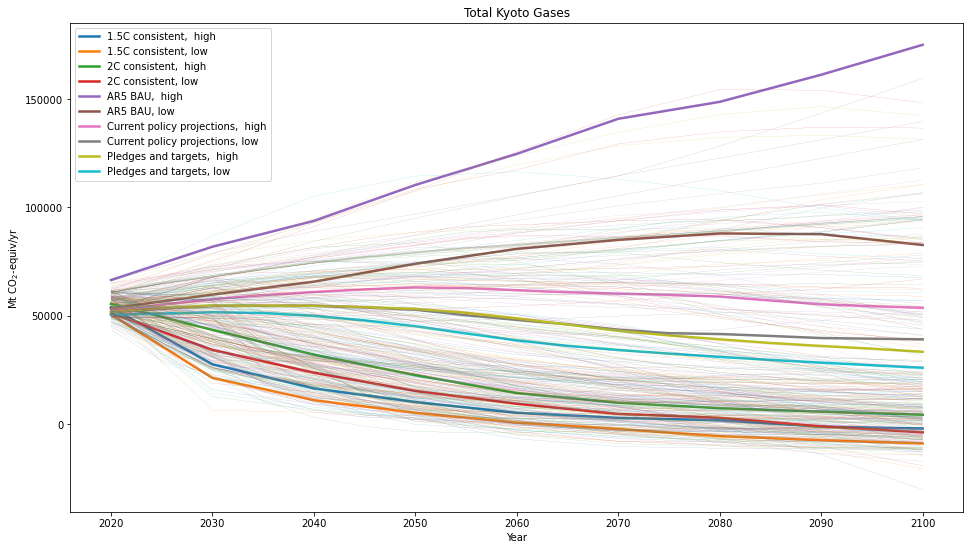

In [11]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
for model, scenario in list(
    zip(kyoto_df.timeseries().index.get_level_values(0).values, kyoto_df.timeseries().index.get_level_values(1).values)
):
    kyoto_df.filter(year=results.data["year"].unique(), model=model, scenario=scenario).line_plot(
        ax=ax, linewidth = 2.5, label=model + ", " + scenario
    )
df.filter(variable=aggregate, year=results.data["year"].unique()).line_plot(
    ax=ax, linewidth=0.1, label='_nolegend_', title="Total Kyoto Gases"
)
ax.set_ylabel("Mt CO$_2$-equiv/yr")

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


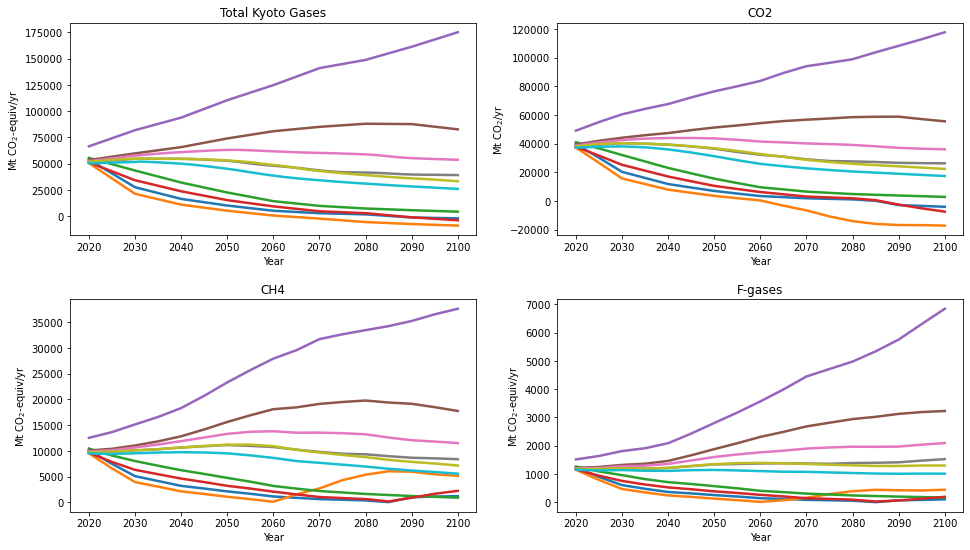

In [12]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    fig = plt.figure(figsize=(16, 9))
    fig.subplots_adjust(hspace=.3)
    ax = fig.add_subplot(221)
    kyoto_df.line_plot(ax=ax, label='_nolegend_', linewidth = 2.5, title="Total Kyoto Gases")
    ax.set_ylabel("Mt CO$_2$-equiv/yr")
    ax.legend(frameon=False)
    ax = fig.add_subplot(222)
    results.filter(variable="Emissions|CO2").line_plot(ax=ax, linewidth = 2.5, label='_nolegend_', title="CO2")
    ax.set_ylabel("Mt CO$_2$/yr")
    ax.legend(frameon=False)
    ax = fig.add_subplot(223)
    results.filter(variable="Emissions|CH4").line_plot(ax=ax, linewidth = 2.5, label='_nolegend_', title="CH4")
    ax.set_ylabel("Mt CO$_2$-equiv/yr")
    ax.legend(frameon=False)
    ax = fig.add_subplot(224)
    results.filter(variable="Emissions|F-Gases").line_plot(ax=ax, linewidth = 2.5, label='_nolegend_', title="F-gases")
    ax.set_ylabel("Mt CO$_2$-equiv/yr")
    ax.legend(frameon=False)

We see here that there is some irregularity introduced in the negative pathways. This is because when the Kyoto total gets more negative, we get a larger positive CH4 and F-gas component, whereas we would expect to get a smaller one due to higher levels of effort in mitigating emissions. 

## Asymmetric approach: treat the carbon separately
The problem with using the other infillers is that they are not guaranteed to preserve the total. The `split_collection_with_remainder_emissions` function will ensure that this happens, with one of the emissions making up the difference. Typically this will be carbon, as it has the largest amount of emissions and also the results can theoretically go negative. The function can use any of the crunchers, although we will use the quantile rolling windows method. 

In [13]:
non_co2_compon = [
    "Emissions|CH4",
    "Emissions|N2O",
    "Emissions|F-Gases",
]
co2 = "Emissions|CO2"
split_remainder = mi.SplitCollectionWithRemainderEmissions(df)
asym_infilled = split_remainder.infill_components(
    aggregate, non_co2_compon, co2, kyoto_df.filter(year=np.arange(2020, 2101, 10)), cr.QuantileRollingWindows
)

In [14]:
asym_infilled.variables(True)

,variable,unit
0,Emissions|CH4,Mt CH4/yr
1,Emissions|CO2,Mt CO2-equiv/yr
2,Emissions|F-Gases,Mt CO2-equiv/yr
3,Emissions|N2O,kt N2O/yr


In [15]:
# By default the variables are returned in the same units they were in the original. 
# We may want them in common units to check out work. 
unit_cons_asym_df = convert_units_to_MtCO2_equiv(asym_infilled)
unit_cons_asym_df.variables(True)

,variable,unit
0,Emissions|CH4,Mt CO2-equiv/yr
1,Emissions|CO2,Mt CO2-equiv/yr
2,Emissions|F-Gases,Mt CO2-equiv/yr
3,Emissions|N2O,Mt CO2-equiv/yr


We now have all the variables we need. Let's plot them. 

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


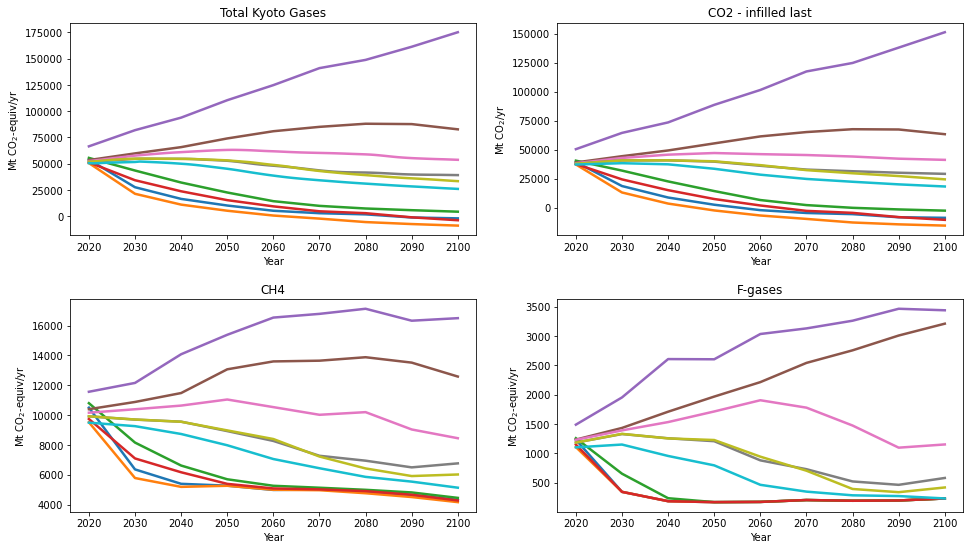

In [16]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    # We plot the results for 3 component gases
    kwargs = {'label':'_nolegend_', 'linewidth': 2.5}
    fig = plt.figure(figsize=(16, 9))
    fig.subplots_adjust(hspace=.3)
    ax = fig.add_subplot(221)
    kyoto_df.line_plot(ax=ax, title="Total Kyoto Gases", **kwargs)
    ax.legend(frameon=False)
    ax.set_ylabel("Mt CO$_2$-equiv/yr")
    ax = fig.add_subplot(222)
    unit_cons_asym_df.filter(variable="Emissions|CO2").line_plot(ax=ax, title="CO2 - infilled last", **kwargs)
    ax.set_ylabel("Mt CO$_2$/yr")
    ax.legend(frameon=False)
    ax = fig.add_subplot(223)
    unit_cons_asym_df.filter(variable="Emissions|CH4").line_plot(ax=ax, title="CH4", **kwargs)
    ax.set_ylabel("Mt CO$_2$-equiv/yr")
    ax.legend(frameon=False)
    ax = fig.add_subplot(224)
    unit_cons_asym_df.filter(variable="Emissions|F-Gases").line_plot(ax=ax, title="F-gases", **kwargs)
    ax.set_ylabel("Mt CO$_2$-equiv/yr")
    ax.legend(frameon=False)

In [17]:
# Check that the infilling correctly matches the Kyoto total: 
correct_cases = return_cases_which_consistently_split(unit_cons_asym_df, aggregate, components)
all_cases = return_cases_which_consistently_split(
    unit_cons_asym_df, aggregate, components, how_close = {"equal_nan": True, "rtol": 10000}
)
print("The number of inconsistently filled in cases is " + str(len(all_cases) - len(correct_cases)))

The number of inconsistently filled in cases is 0
